In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize


In [4]:
# Problem parameters
n_lamps = 10
grid_size = 25
m_pixels = grid_size * grid_size  # 625 pixels

print(f"Number of lamps: {n_lamps}")
print(f"Grid size: {grid_size}x{grid_size} = {m_pixels} pixels")

Number of lamps: 10
Grid size: 25x25 = 625 pixels


In [5]:
lamp_positions = np.array([
        [4.1, 20.4, 4.0],
        [14.1, 21.3, 3.5],
        [22.6, 17.1, 6.0],
        [5.5, 12.3, 4.0],
        [12.2, 9.7, 4.0],
        [15.3, 13.8, 6.0],
        [21.3, 10.5, 5.5],
        [3.9, 3.3, 5.0],
        [13.1, 4.3, 5.0],
        [20.3, 4.2, 4.5]
    ])

print(f"Lamp positions shape {lamp_positions.shape}")

Lamp positions shape (10, 3)


In [6]:
# Create pixel centers (each pixel is 1m x 1m)
x_coords = np.arange(0.5, grid_size, 1.0)  # 0.5, 1.5, 2.5, ..., 24.5
y_coords = np.arange(0.5, grid_size, 1.0)

# Create all pixel positions
pixel_positions = []
for y in y_coords:
    for x in x_coords:
        pixel_positions.append([x, y, 0.0])  # z=0 (floor level)

pixel_positions = np.array(pixel_positions)
print(f"Pixel positions shape: {pixel_positions.shape}")
print(f"First pixel: {pixel_positions[0]}")
print(f"Last pixel: {pixel_positions[-1]}")

Pixel positions shape: (625, 3)
First pixel: [0.5 0.5 0. ]
Last pixel: [24.5 24.5  0. ]


In [8]:
# Initialize matrix A (625 pixels x 10 lamps)
A = np.zeros((m_pixels, n_lamps))

In [9]:
print("Computing illumination matrix...")

# For each lamp and each pixel, compute illumination contribution
for j in range(n_lamps):  # for each lamp
    for i in range(m_pixels):  # for each pixel
        # Calculate 3D distance between lamp j and pixel i
        distance = np.sqrt(np.sum((lamp_positions[j] - pixel_positions[i])**2))
        # Inverse square law
        A[i, j] = 1.0 / (distance**2)

# Scale A so that average illumination is 1 when all lamps have power 1
illumination_all_ones = A @ np.ones(n_lamps)  # A times vector of all ones
average_illumination = np.mean(illumination_all_ones)
A = A / average_illumination

print(f"Matrix A shape: {A.shape}")
print(f"Average illumination with all lamps = 1: {np.mean(A @ np.ones(n_lamps)):.3f}")

Computing illumination matrix...
Matrix A shape: (625, 10)
Average illumination with all lamps = 1: 1.000


In [10]:
# Desired illumination: uniform with value 1 everywhere
l_desired = np.ones(m_pixels)


In [32]:
# Strategy 1: All lamps have power 1
p_uniform = np.ones(n_lamps)
l_uniform = A @ p_uniform

print(l_uniform)

[0.51016854 0.56776684 0.62166284 0.6647521  0.69226156 0.70519018
 0.70978723 0.71357564 0.72182027 0.73629413 0.75550606 0.77549552
 0.79130006 0.79926492 0.7990975  0.79381795 0.78734236 0.78147349
 0.77412779 0.75981958 0.73275121 0.69092356 0.63768061 0.5793136
 0.52158476 0.55755316 0.62752323 0.69385648 0.7462757  0.77747039
 0.78896869 0.79028567 0.79233861 0.80226044 0.82214561 0.84959966
 0.8785857  0.90124102 0.91162931 0.90963222 0.9010274  0.89311357
 0.88951507 0.88712203 0.87645697 0.84685555 0.79447697 0.72535884
 0.65019146 0.5776942  0.59778993 0.67820263 0.75541055 0.81646317
 0.85177514 0.86335899 0.86366115 0.86650212 0.88052378 0.90805461
 0.9458486  0.98567267 1.01622907 1.02868277 1.02321213 1.00932088
 0.9987312  0.9975183  1.00160976 0.99660681 0.96524612 0.90112924
 0.81415993 0.72076654 0.63291633 0.62623771 0.7123966  0.79578837
 0.86267129 0.90278715 0.9183472  0.92280972 0.93107369 0.95245779
 0.98942904 1.03809042 1.08832724 1.12576932 1.13900821 1.12875

In [ ]:
# Calculate error for uniform strategy
error_uniform = l_uniform - l_desired
rms_error_uniform = np.sqrt(np.mean(error_uniform**2))

print(f"\nStrategy 1 - All lamps power = 1:")
print(f"RMS error: {rms_error_uniform:.4f}")
print(f"Min illumination: {np.min(l_uniform):.3f}")
print(f"Max illumination: {np.max(l_uniform):.3f}")



Strategy 1 - All lamps power = 1:
RMS error: 0.2417
Min illumination: 0.402
Max illumination: 1.594


In [34]:
# Strategy 2: Least squares optimal powers
# Solve: minimize ||Ap - l_desired||^2
p_optimal = np.linalg.lstsq(A, l_desired, rcond=None)[0]
l_optimal = A @ p_optimal

print(f"\nOptimal lamp powers: {p_optimal}")
print(l_optimal)


Optimal lamp powers: [1.46211018 0.78797433 2.96641047 0.74358042 0.08317333 0.21263945
 0.21218408 2.05114815 0.90760315 1.47222464]
[0.70838268 0.79755654 0.87647054 0.93031867 0.9490465  0.93443814
 0.89913218 0.85864682 0.82445685 0.80193445 0.79131141 0.78939445
 0.79154878 0.79409822 0.79627461 0.8001072  0.80800058 0.81960627
 0.82984746 0.82960309 0.80994239 0.76785393 0.70829224 0.64052799
 0.57298909 0.7792504  0.88956281 0.98915076 1.05660835 1.07653313
 1.0515805  1.00080063 0.94635344 0.9033129  0.8778319  0.86921418
 0.87218206 0.87932952 0.88482908 0.88803337 0.89348279 0.90664656
 0.92854095 0.95205959 0.96221969 0.94316665 0.88944351 0.8101619
 0.72115663 0.6352085  0.83332245 0.96021645 1.07661345 1.1555552
 1.17684295 1.14389756 1.08144181 1.01718201 0.96895455 0.94344658
 0.93920358 0.94900913 0.96243306 0.97104608 0.97441169 0.98039687
 0.99850218 1.03184263 1.07146216 1.09533166 1.07830113 1.01154222
 0.91010746 0.79835541 0.69378931 0.86086802 0.99396507 1.11674

In [36]:
# Calculate error for optimal strategy
error_optimal = l_optimal - l_desired
rms_error_optimal = np.sqrt(np.mean(error_optimal**2))

print(f"RMS error: {rms_error_optimal:.4f}")
print(f"Min illumination: {np.min(l_optimal):.3f}")
print(f"Max illumination: {np.max(l_optimal):.3f}")

print(f"\nImprovement: {rms_error_uniform/rms_error_optimal:.2f}x better")

RMS error: 0.1404
Min illumination: 0.535
Max illumination: 1.337

Improvement: 1.72x better


Methods that will be used to show colormap with the results

In [45]:
def create_single_colormap(l_matrix, rms_error, lamp_positions, ax, title):
    grid = l_matrix.reshape(25, 25)
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 8))
        show_plot = True
    else:
        show_plot = False
    
    # Plot heatmap
    im = ax.imshow(grid, extent=[0, 25, 0, 25], origin='lower', 
                   cmap='RdYlBu_r', vmin=0.5, vmax=1.5)
    
    # Mark lamps
    for i, (x, y, h) in enumerate(lamp_positions):
        ax.plot(x, y, 'ko', markersize=8)
        ax.annotate(f'{i+1} ({h}m)', (x, y), xytext=(5, 5), 
                   textcoords='offset points', fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    
    ax.set_title(f'{title}\nRMS Error: {rms_error:.4f}', fontweight='bold')
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    plt.colorbar(im, ax=ax, label='Illumination Level')
    
    if show_plot:
        plt.tight_layout()
        plt.show()

def create_multiple_colormap(plot_data, lamp_positions):
    n_plots = len(plot_data)
    fig, axes = plt.subplots(1, n_plots, figsize=(10*n_plots, 8))
    
    # Handle single plot case
    if n_plots == 1:
        axes = [axes]
    
    for i, (l_matrix, rms_error, title) in enumerate(plot_data):
        create_single_colormap(l_matrix, rms_error, lamp_positions, axes[i], title)
    
    plt.tight_layout()
    plt.show()

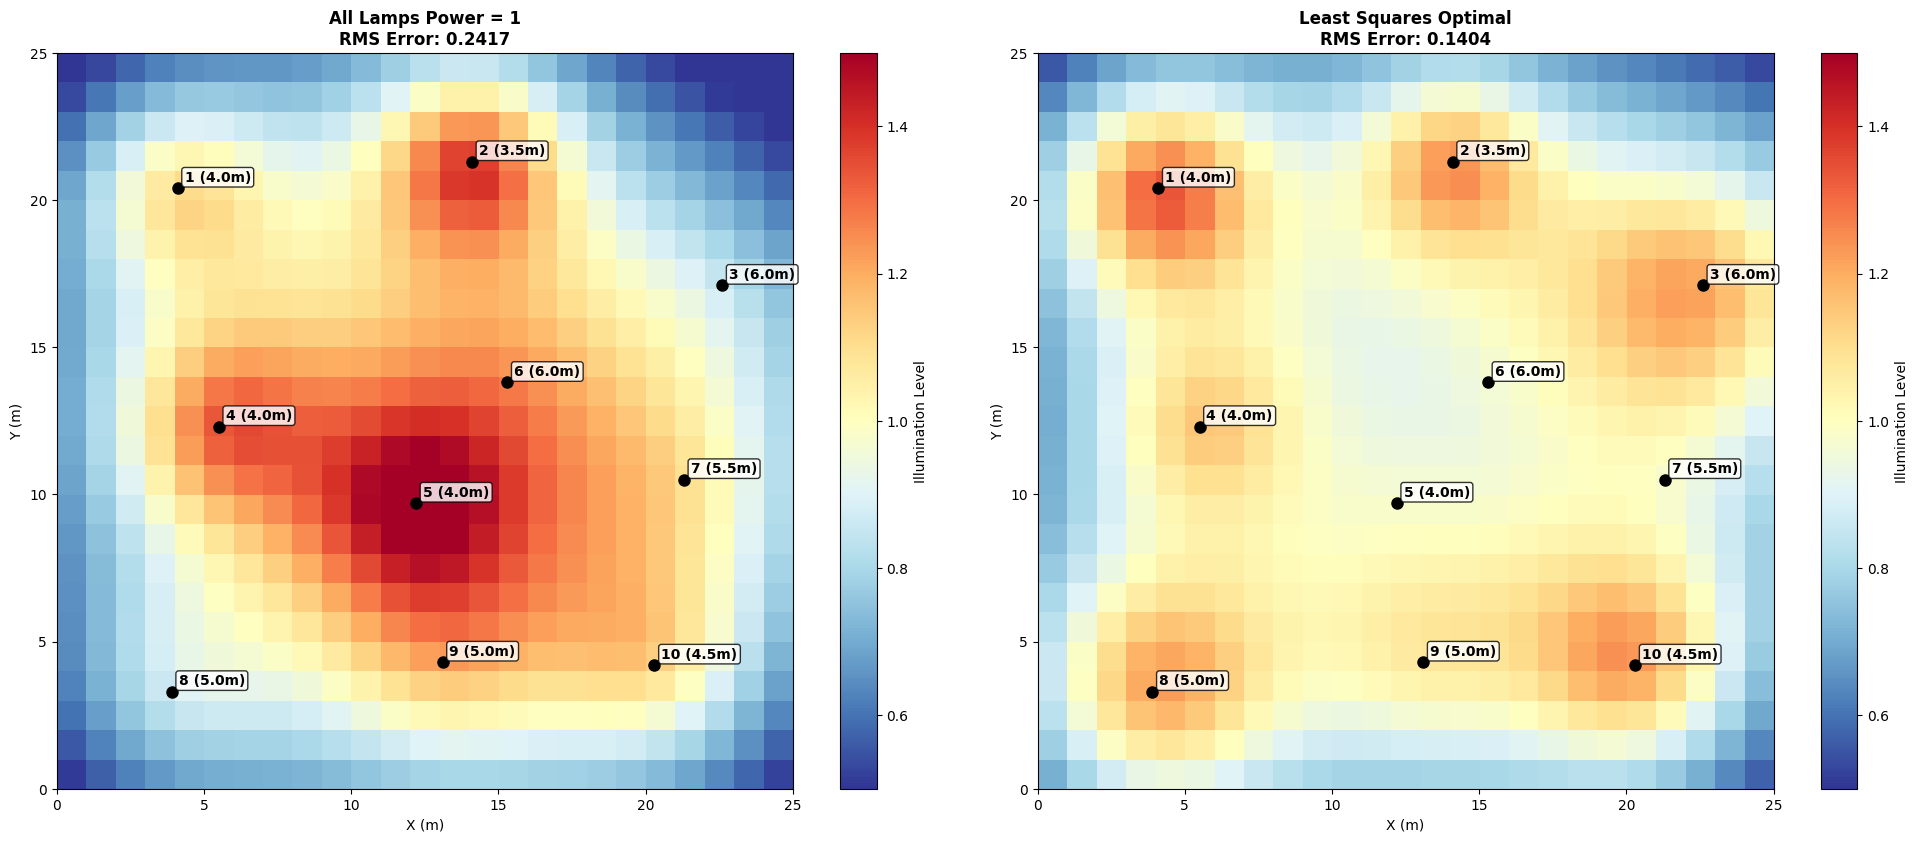

In [46]:
plot_data = [
    (l_uniform, rms_error_uniform, "All Lamps Power = 1"),
    (l_optimal, rms_error_optimal, "Least Squares Optimal")
]
create_multiple_colormap(plot_data, lamp_positions)

In [49]:
def create_single_histogram(l_matrix, title, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        show_plot = True
    else:
        show_plot = False
    
    ax.hist(l_matrix, bins=30, alpha=0.7, color='blue', edgecolor='black')
    ax.set_title(f'Illumination Distribution\n({title})', fontweight='bold')
    ax.set_xlabel('Illumination Level')
    ax.set_ylabel('Number of Pixels')
    ax.axvline(1.0, color='red', linestyle='--', linewidth=2, label='Desired Level')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    if show_plot:
        plt.tight_layout()
        plt.show()

def create_multiple_histograms(histogram_data):
    n_plots = len(histogram_data)
    fig, axes = plt.subplots(1, n_plots, figsize=(7*n_plots, 5))
    
    # Handle single plot case
    if n_plots == 1:
        axes = [axes]
    
    for i, (l_matrix, title) in enumerate(histogram_data):
        create_single_histogram(l_matrix, title, axes[i])
    
    plt.tight_layout()
    plt.show()

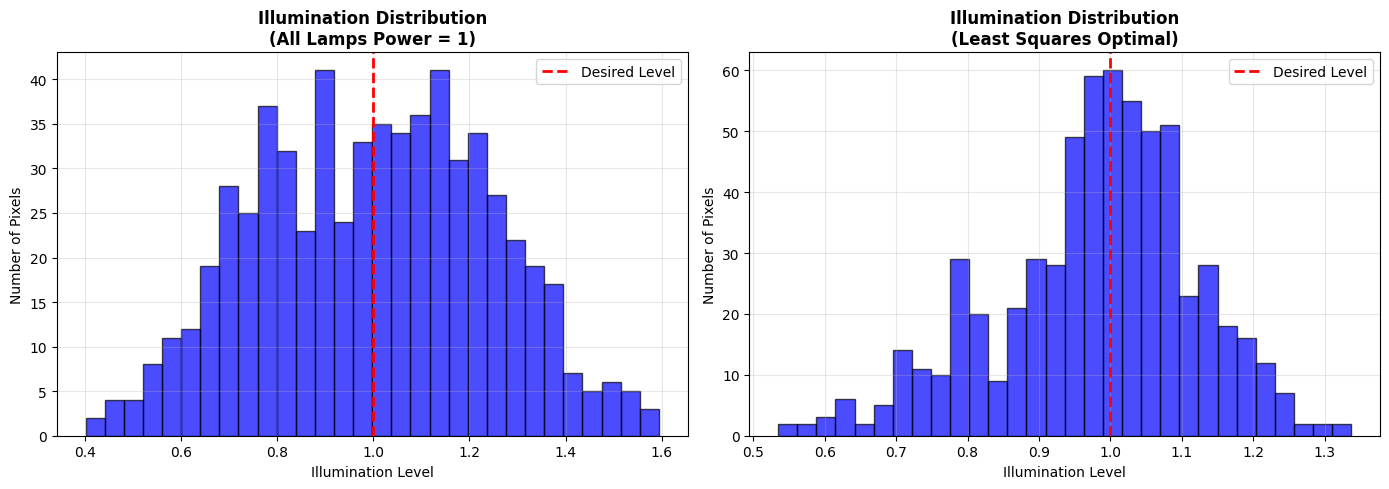

In [50]:
histogram_data = [
    (l_uniform, "All Lamps Power = 1"),
    (l_optimal, "Least Squares Optimal")
]

create_multiple_histograms(histogram_data)

In [ ]:
def objective(p):
    illumination = A @ p
    return np.sum((illumination - 1)**2)  # Same as least squares

# Constraints
constraints = [
    {'type': 'eq', 'fun': lambda p: np.sum(p) - 10},  # Total power = 10
]

# Bounds for non-negative powers
bounds = [(0, None) for _ in range(10)]  # Each p[i] >= 0

# Solve
result = minimize(objective, x0=np.ones(10), constraints=constraints, bounds=bounds)
p_constrained = result.x

l_constrained = A @ p_constrained

print(f"\nConstrained lamp powers: {p_constrained.round(2)}")
print(l_constrained)


Constrained lamp powers: [1.34 0.89 2.37 0.78 0.32 0.   0.4  1.76 0.76 1.38]
[0.63254496 0.71095177 0.78060783 0.82876569 0.84675993 0.83610031
 0.80762499 0.77464385 0.74699026 0.72926267 0.72167271 0.72154184
 0.72501055 0.72907199 0.73319398 0.73917241 0.74899957 0.76210217
 0.77357027 0.77479416 0.75740163 0.71860326 0.66309711 0.59963854
 0.53619663 0.69571283 0.79262221 0.88041042 0.94065236 0.96008099
 0.94095138 0.89960787 0.85505762 0.82020454 0.80028466 0.79468123
 0.79892094 0.80680826 0.81357664 0.81890011 0.82682637 0.84205363
 0.86517832 0.88935316 0.90047662 0.88369722 0.8339451  0.75983103
 0.6762842  0.59537726 0.7447234  0.85629361 0.95897806 1.02957401
 1.05068802 1.02523293 0.97442977 0.92204577 0.88333126 0.86392537
 0.86248602 0.87282105 0.88615283 0.89557756 0.90109284 0.90975603
 0.92987398 0.96392027 1.00329888 1.02730796 1.01237947 0.95027759
 0.85518711 0.75004664 0.65138418 0.77124769 0.88865222 0.99737622
 1.07280962 1.09631004 1.07097462 1.0195108  0.9672

In [44]:
# Calculate error for optimal strategy
error_constrained = l_constrained - l_desired
rms_error_constrained = np.sqrt(np.mean(error_constrained**2))

print(f"RMS error: {rms_error_constrained:.4f}")
print(f"Min illumination: {np.min(l_constrained):.3f}")
print(f"Max illumination: {np.max(l_constrained):.3f}")

print(f"\nImprovement: {rms_error_uniform/rms_error_constrained:.2f}x better")

RMS error: 0.1558
Min illumination: 0.472
Max illumination: 1.256

Improvement: 1.55x better


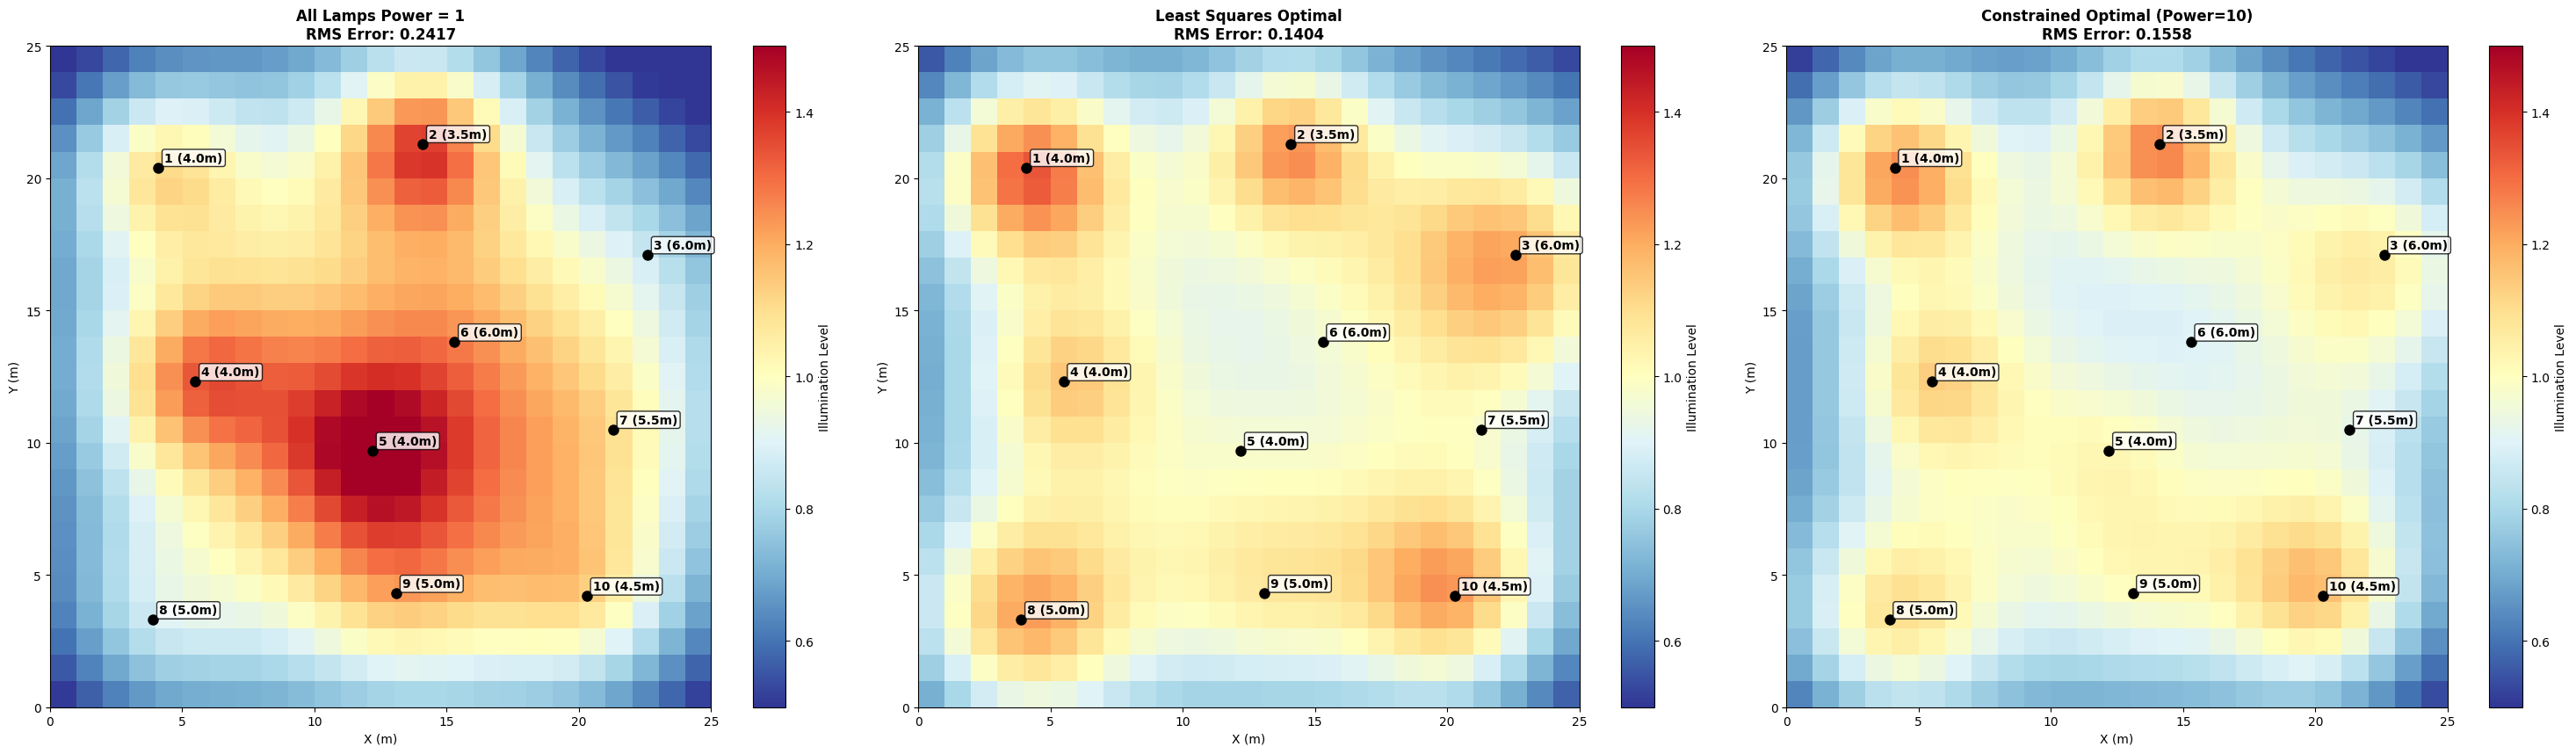

In [48]:
plot_data = [
    (l_uniform, rms_error_uniform, "All Lamps Power = 1"),
    (l_optimal, rms_error_optimal, "Least Squares Optimal"),
    (l_constrained, rms_error_constrained, "Constrained Optimal (Power=10)")
]
create_multiple_colormap(plot_data, lamp_positions)

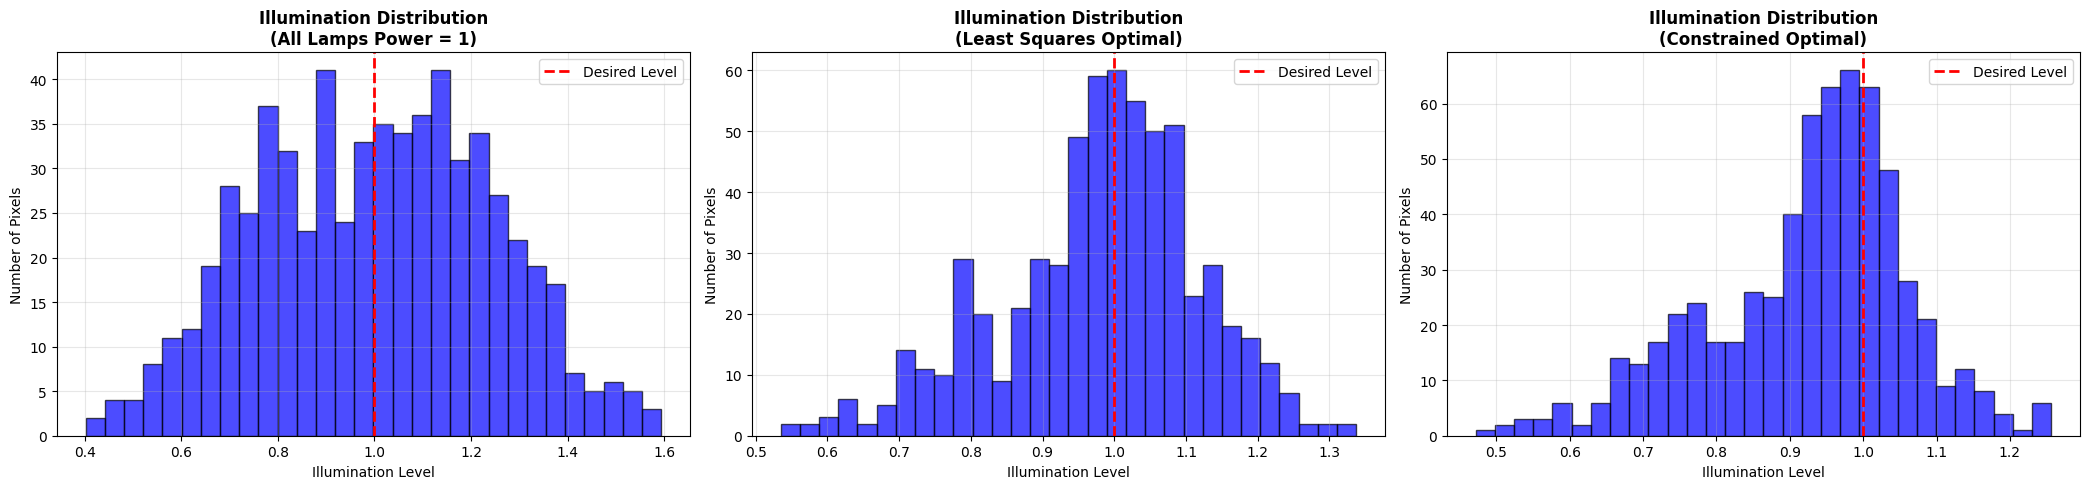

In [51]:
histogram_data = [
    (l_uniform, "All Lamps Power = 1"),
    (l_optimal, "Least Squares Optimal"),
    (l_constrained, "Constrained Optimal")
]
create_multiple_histograms(histogram_data)

In [ ]:
def objective_function(positions_flat):
    positions = positions_flat.reshape(10, 3)
    
    # Recompute A matrix
    A_new = np.zeros((m_pixels, n_lamps))
    for j in range(n_lamps):
        for i in range(m_pixels):
            distance = np.linalg.norm(positions[j] - pixel_positions[i])
            A_new[i, j] = 1.0 / distance**2
    A_new = A_new / np.mean(A_new @ np.ones(n_lamps))
    
    # Solve for powers: sum(p)=10, p>=0
    result = minimize(lambda p: np.sum((A_new @ p - 1)**2), 
                     np.ones(n_lamps),
                     constraints=[{'type': 'eq', 'fun': lambda p: np.sum(p) - 10}],
                     bounds=[(0, None)]*n_lamps)
    
    return np.sqrt(np.mean((A_new @ result.x - 1)**2))

In [ ]:
# Bounds: x,y in [0,25], height in [4,6]
bounds = [(0, 25), (0, 25), (4, 6)] * n_lamps

# Optimize
result = minimize(objective_function, lamp_positions.flatten(), bounds=bounds)
optimized_positions = result.x.reshape(10, 3)

# Compute final results
A_opt = np.zeros((m_pixels, n_lamps))
for j in range(n_lamps):
    for i in range(m_pixels):
        A_opt[i, j] = 1.0 / np.linalg.norm(optimized_positions[j] - pixel_positions[i])**2
A_opt = A_opt / np.mean(A_opt @ np.ones(n_lamps))

p_opt = minimize(lambda p: np.sum((A_opt @ p - 1)**2), np.ones(n_lamps),
                constraints=[{'type': 'eq', 'fun': lambda p: np.sum(p) - 10}],
                bounds=[(0, None)]*n_lamps).x
l_opt = A_opt @ p_opt


Optimizing positions...


In [55]:
rms_opt = np.sqrt(np.mean((l_opt - 1)**2))

print(f"Original RMS: {rms_error_constrained:.4f}")
print(f"Optimized RMS: {rms_opt:.4f}")
print(f"Improvement: {rms_error_constrained/rms_opt:.2f}x")

Original RMS: 0.1558
Optimized RMS: 0.0298
Improvement: 5.22x


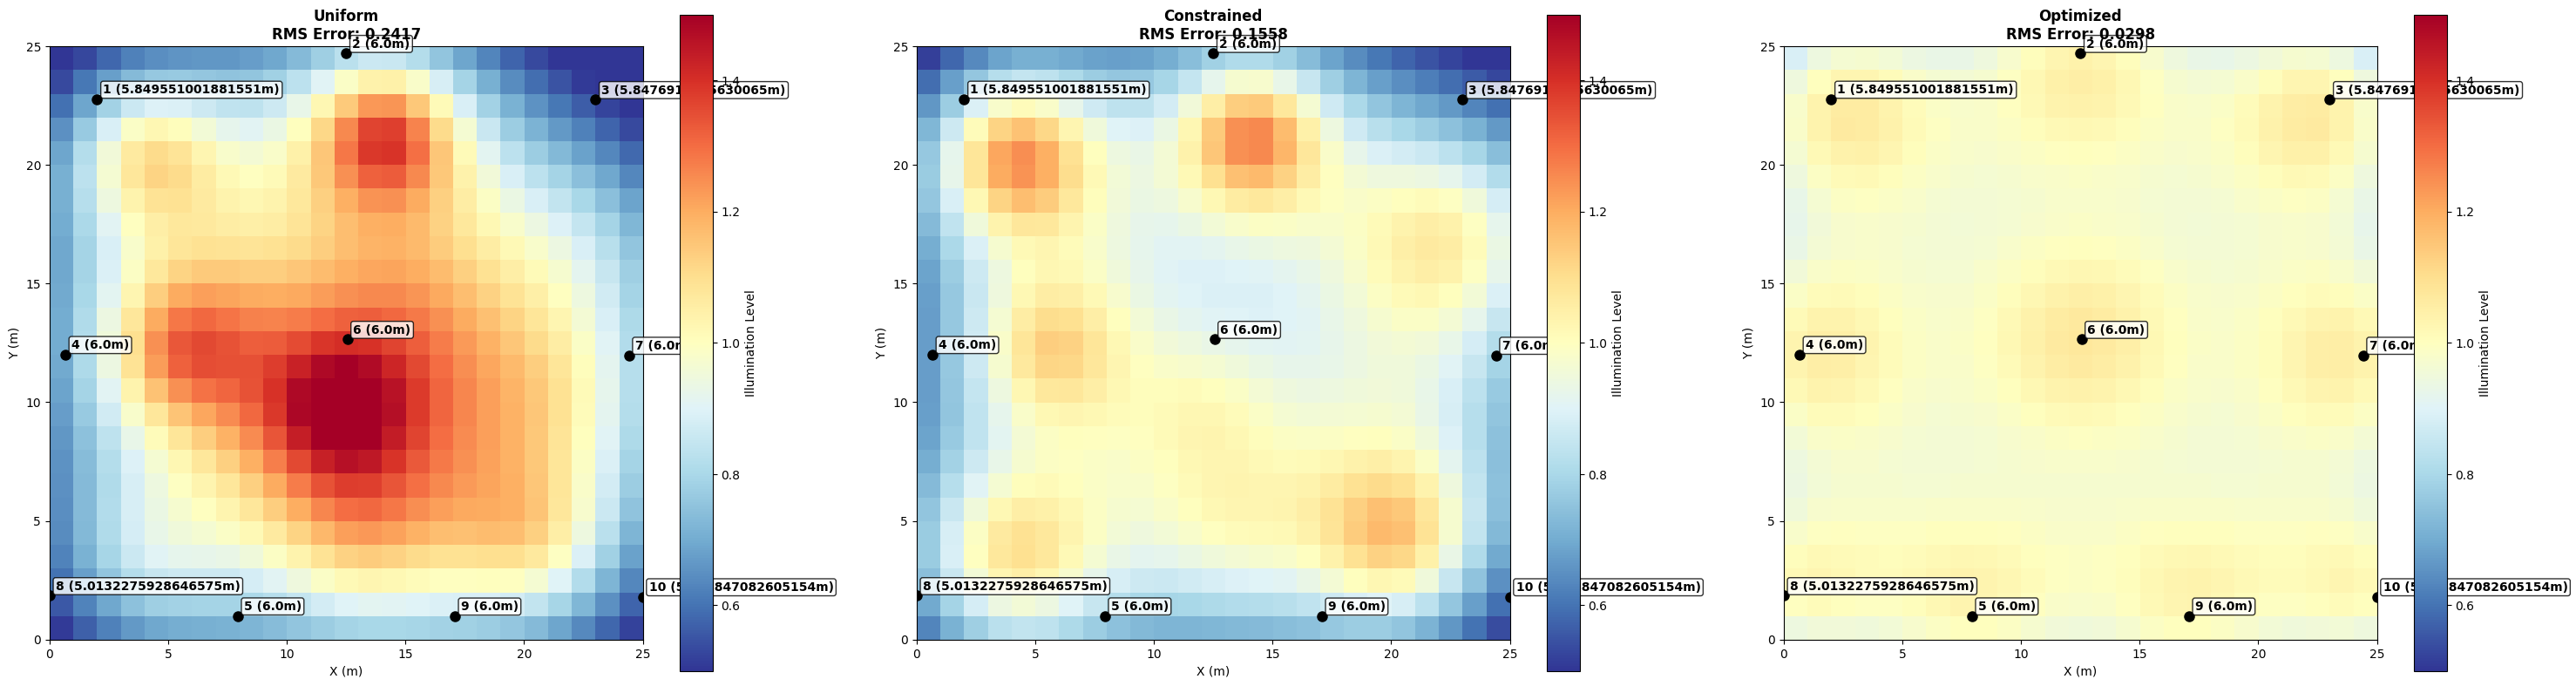

In [56]:
# Plot results
plot_data = [(l_uniform, rms_error_uniform, "Uniform"), 
             (l_constrained, rms_error_constrained, "Constrained"), 
             (l_opt, rms_opt, "Optimized")]
create_multiple_colormap(plot_data, optimized_positions)

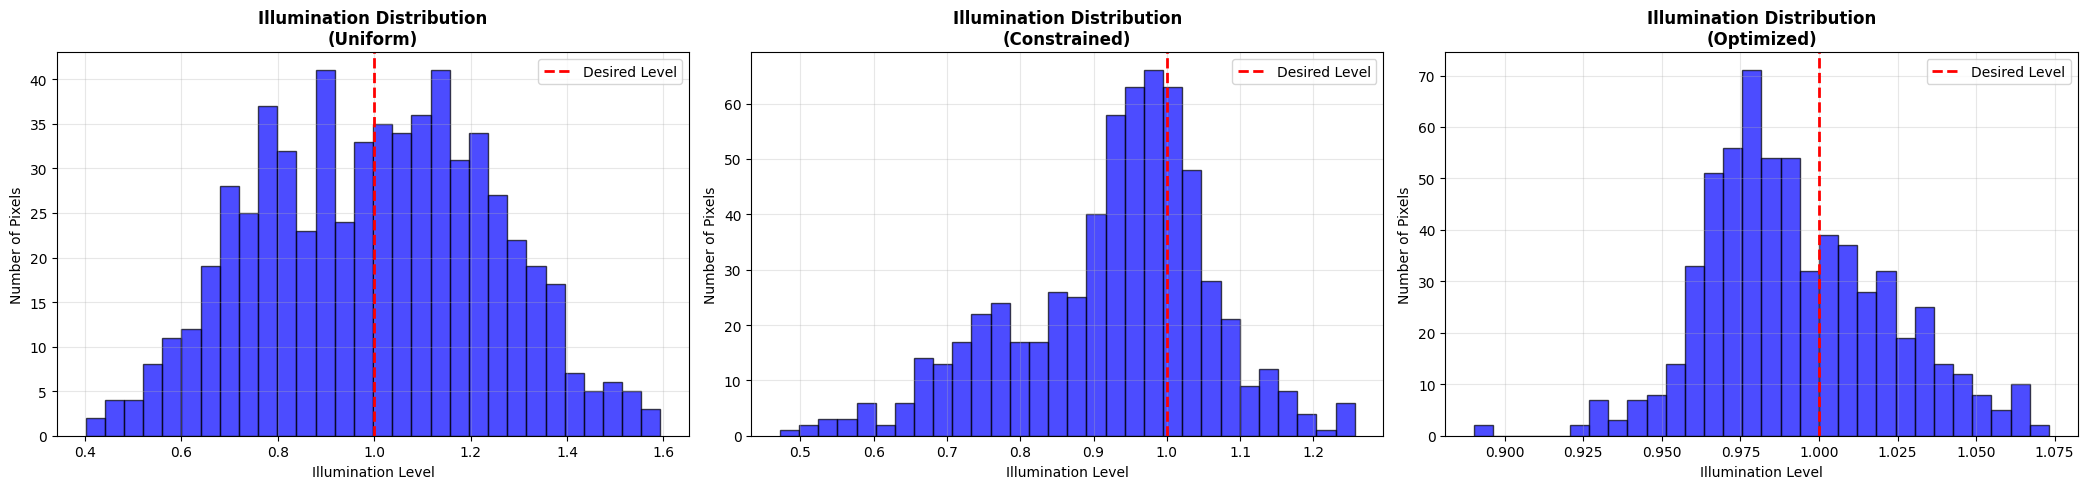

In [57]:
histogram_data = [(l_uniform, "Uniform"), (l_constrained, "Constrained"), (l_opt, "Optimized")]
create_multiple_histograms(histogram_data)